In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data
import json
from tqdm.auto import tqdm
from src.metrics import AggregateMetric
import logging

from src.utils import logging_utils

# logging_utils.configure(level=logging.DEBUG)

## Loading the results

In [3]:
############################################
sweep_root = "../../results/SWEEP"
# sweep_root = "../../results/sweep-bare"
# model_name = "mamba-3b"
model_name = "pythia-3b"
############################################

sweep_path = os.path.join(sweep_root, model_name)

# sweep_path = "../../results/test"

In [4]:
from src.utils.sweep_utils import read_sweep_results, relation_from_dict

In [5]:
sweep_results = read_sweep_results(sweep_path, economy=True)
list(sweep_results.keys())

['person occupation',
 'landmark in country',
 'adjective antonym',
 'person mother',
 'country capital city',
 'plays pro sport',
 'person plays instrument',
 'person university',
 'city in country',
 'food from country',
 'company hq',
 'occupation gender',
 'name gender',
 'word first letter',
 'country language',
 'object superclass',
 'name religion',
 'person native language',
 'fruit outside color',
 'superhero archnemesis',
 'work location',
 'landmark on continent',
 'person lead singer of band',
 'task person type',
 'characteristic gender',
 'country largest city',
 'country currency',
 'fruit inside color',
 'task done by tool',
 'verb past tense',
 'star constellation name',
 'pokemon evolution',
 'product by company',
 'name birthplace',
 'word last letter',
 'word sentiment',
 'company CEO',
 'superhero person',
 'person father',
 'substance phase of matter',
 'person sport position',
 'adjective superlative',
 'adjective comparative',
 'univ degree gender']

In [6]:
# sweep_results_bare = read_sweep_results("../../results/sweep-bare/gptj", economy=True)
# list(sweep_results_bare.keys())

In [7]:
relation_name = "country capital city"
relation_result = relation_from_dict(sweep_results[relation_name])
# relation_result_bare = relation_from_dict(sweep_results_bare[relation_name])

In [8]:
efficacy = relation_result.best_by_efficacy()
print(f"best by efficacy =>  layer={efficacy.layer}, beta={efficacy.beta.mean:.2f}, rank={efficacy.rank.mean:.0f}")
print("recall:", efficacy.recall)
print("efficacy:", efficacy.efficacy)

print("-------------------------------------------------------------")

faithfulness = relation_result.best_by_faithfulness()
print(f"best by faithfulness => layer={faithfulness.layer}, beta={faithfulness.beta.mean:.2f}, rank={faithfulness.rank.mean:.0f}")
print("recall:", faithfulness.recall)
print("efficacy:", faithfulness.efficacy)

best by efficacy =>  layer=5, beta=2.80, rank=70
recall: 0.85 ± 0.01
efficacy: 0.97 ± 0.01
-------------------------------------------------------------
best by faithfulness => layer=13, beta=1.98, rank=52
recall: 0.88 ± 0.01
efficacy: 0.95 ± 0.01


In [9]:
beta = 5

efficacy = relation_result.best_by_efficacy(beta = beta)
print(f"best by efficacy =>  layer={efficacy.layer}, beta={efficacy.beta.mean:.2f}, rank={efficacy.rank.mean:.0f}")
print("recall:", efficacy.recall)
print("efficacy:", efficacy.efficacy)

print("-------------------------------------------------------------")

faithfulness = relation_result.best_by_faithfulness(beta = beta)
print(f"best by faithfulness => layer={faithfulness.layer}, beta={faithfulness.beta.mean:.2f}, rank={faithfulness.rank.mean:.0f}")
print("recall:", faithfulness.recall)
print("efficacy:", faithfulness.efficacy)

best by efficacy =>  layer=5, beta=5.00, rank=70
recall: 0.80 ± 0.02
efficacy: 0.97 ± 0.01
-------------------------------------------------------------
best by faithfulness => layer=2, beta=5.00, rank=46
recall: 0.82 ± 0.02
efficacy: 0.97 ± 0.01


In [10]:
##############################################################################
fig_dir = f"figs/{model_name}"
##############################################################################

In [11]:
plt.rcdefaults()
os.makedirs(fig_dir, exist_ok=True)
#####################################################################################
plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=MEDIUM_SIZE+1)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=50)  # fontsize of the figure title
#####################################################################################

color_scheme = {
    "recall": "steelblue",
    "efficacy": "darkorange",
}

legend_labels = {
    "recall": "Faithfulness",
    "efficacy": "Causality",
}

def plot_layerwise(
        canvas, relation_result, 
        attribute = "recall", best_criterion = "faithfulness", 
        color = None, label = None,
        linewidth = 2
    ):
    by_layer = relation_result.by_layer()

    layers = list(by_layer.keys())
    value_means = [value.__dict__[attribute].mean for value in by_layer.values()]
    value_stds = [value.__dict__[attribute].stdev for value in by_layer.values()]

    if(best_criterion == "faithfulness"):
        best_layer = relation_result.best_by_faithfulness()
    elif(best_criterion == "efficacy"):
        best_layer = relation_result.best_by_efficacy()
    
    color = color_scheme[attribute] if color is None else color
    label = legend_labels[attribute] if label is None else label
    
    # canvas.scatter([layers.index(best_layer.layer)], [best_layer.__dict__[attribute].mean], color="red", s=200)
    canvas.plot(range(len(layers)), value_means, color=color, linewidth=linewidth, label = label)
    canvas.fill_between(range(len(layers)), np.array(value_means) - np.array(value_stds), np.array(value_means) + np.array(value_stds), color=color, alpha=0.07)

    if attribute in ["recall", "efficacy"]:
        canvas.set_ylim(0, 1)
    else:
        canvas.set_ylim(bottom=0)
    canvas.set_xlabel("Layer")
    canvas.set_ylabel(attribute)
    canvas.set_xticks(range(len(layers)), layers, rotation=90)
    test_samples = [trial.n_test_samples for trial in relation_result.trials]
    test_samples = np.array(test_samples)
    trial_info = f"[{test_samples.mean():.2f} ± {test_samples.std():.2f}]"
    canvas.set_title(f"{relation_result.relation_name} n_trials={len(test_samples)} {trial_info}\n{best_criterion} => h_layer: {best_layer.layer}, beta: {best_layer.beta.mean:.2f}, rank: {best_layer.rank.mean:.2f}, efficacy: {best_layer.efficacy.mean:.2f}")
    
    return canvas

In [12]:
def export_legend(legend, filename="legend.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

In [13]:
# nrows = 1
# ncols = 1
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6))
# plot_layerwise(ax, relation_result, color = "steelblue", label="With relation-specific prompt", linewidth=2.5)
# plot_layerwise(ax, relation_result_bare, color = "#00e6b8", label="W/o relation-specific prompt", linewidth=2.5)
# # plot_layerwise(ax, relation_result, attribute="efficacy", best_criterion="efficacy")
# ax.set_ylabel("Faithfulness")
# ax.set_title("", fontsize=BIGGER_SIZE, pad=10)
# legend = plt.legend(ncol = 2, bbox_to_anchor=(0.5, 1.15), loc='upper center', frameon=False)

# export_legend(legend, f"{fig_dir}/legend-faith-causal.pdf")
# legend.remove()
# fig.tight_layout()
# plt.savefig(f"{fig_dir}/{model_name}-layer-mode-switch.pdf", bbox_inches="tight")
# # plt.savefig(f"{fig_dir}/{model_name}-sweep-bare.pdf", bbox_inches="tight")
# plt.show()

In [14]:
dataset = data.load_dataset()
all_relations = [
    relation.name for relation in dataset.relations
]
all_relations = sorted(all_relations)
# all_relations
failed_relations = list(set(all_relations) - set(sweep_results.keys()))
failed_relations = sorted(failed_relations)

failed_relations

['occupation age', 'president birth year', 'president election year']

In [15]:
# ############################################
# efficacy_root = "../../results/efficacy_baselines-24-trials"
# ############################################""

# efficacy_path = f"{efficacy_root}/{model_name}"

In [16]:
from src.utils.sweep_utils import read_efficacy_baseline_results, format_efficacy_baseline_results

# efficacy_baseline_results = read_efficacy_baseline_results(efficacy_path)

# print(len(efficacy_baseline_results))
# list(efficacy_baseline_results.keys())

In [17]:
# relation_name = "work location"
# relation_result = relation_from_dict(sweep_results[relation_name])
# # format_efficacy_baseline_results(
# #     efficacy_baseline_results[relation_name]
# # )

In [18]:
# plt.rcdefaults()
# #####################################################################################
# plt.rcdefaults()
# plt.rcParams["figure.dpi"] = 200
# plt.rcParams["font.family"] = "Times New Roman"

# SMALL_SIZE = 14
# MEDIUM_SIZE = 18
# BIGGER_SIZE = 22

# plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
# plt.rc("axes", labelsize=MEDIUM_SIZE+1)  # fontsize of the x and y labels
# plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
# plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
# plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
# plt.rc("figure", titlesize=50)  # fontsize of the figure title
# #####################################################################################

# nrows = 1
# ncols = 1
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6))
# plot_layerwise(ax, relation_result, attribute="efficacy", best_criterion="efficacy")
# plot_efficacy_baseline(ax, efficacy_result)
# ax.set_ylabel("Success @ 1")
# ax.set_title(relation_name, fontsize=BIGGER_SIZE, pad=10)
# ax.legend(ncol = 1, bbox_to_anchor=(1, 1), loc='upper right')

# plt.savefig(f"{fig_dir}/{model_name}-causality_baselines.pdf", bbox_inches="tight")
# plt.show()

In [19]:
# ranks = {
#     layer : layer_summary.rank.values
#     for layer, layer_summary in relation_result.by_layer().items()
# }
# ranks

In [20]:
dataset = data.load_dataset()
interested_dataset = dataset.filter(
    # relation_type = ["factual"]
)

filtered_results = {}
for relation_name in tqdm(interested_dataset.relations):
    if relation_name.name not in sweep_results:
        continue
    relation_result = relation_from_dict(sweep_results[relation_name.name])
    if len(relation_result.trials) < (3 if model_name != "llama-13b" else 2):
        print(f"skipping {relation_name.name}, not enough trials, : {[trial.n_test_samples for trial in relation_result.trials]}")
        continue
    filtered_results[relation_name.name] = relation_result

  0%|          | 0/47 [00:00<?, ?it/s]

skipping characteristic gender, not enough trials, : [13]
skipping company hq, not enough trials, : [250, 289]
skipping person native language, not enough trials, : [761, 761]


In [21]:
# saving hparams

from src import hparams

for relation_name in filtered_results:
    sweep_result = filtered_results[relation_name]
    beta = beta=2.25 if "llama" not in model_name else 8.0
    best_by_f = sweep_result.best_by_faithfulness(beta = beta)
    best_by_e = sweep_result.best_by_efficacy(beta = beta)
    hparams.RelationHParams(
        relation_name=sweep_result.relation_name,
        h_layer=best_by_f.layer,  # type: ignore
        h_layer_edit=best_by_e.layer,  # type: ignore
        z_layer=-1,
        beta=best_by_f.beta.mean,
        rank=int(best_by_e.rank.mean),
        model_name=model_name if "llama" not in model_name else "llama",
    ).save()

## Sweep Figures

In [22]:
# plt.rcdefaults()

# step_size = 3

# for _from in range(0, len(filtered_results), step_size):
#     _to = min(len(filtered_results), _from + step_size)
#     n_subplots = len(filtered_results) * 3
#     n_subplots = (_to - _from)  * 2
#     ncols=2
#     nrows=int(np.ceil(n_subplots/ncols))
#     fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6.5))
#     if n_subplots == 1:
#         axes = [axes]
#     if nrows == 1:
#         axes = [axes]

#     ax_col, ax_row = 0, 0
#     for i, (relation_name, relation_result) in list(enumerate(filtered_results.items()))[_from  : _to]:
#         print(i, relation_name)
#         result = filtered_results[relation_name]
#         plot_layerwise(axes[ax_row][0], result)
#         plot_layerwise(axes[ax_row][1], result, attribute="efficacy", best_criterion="efficacy")
#         # if(relation_name in efficacy_baseline_results):
#         #     efficacy_baselines = format_efficacy_baseline_results(efficacy_baseline_results[relation_name])
#         #     plot_efficacy_baseline(axes[ax_row][1], efficacy_baselines)
#         ax_row += 1

#     fig.tight_layout()
#     fig.show()

In [23]:
relation_result = filtered_results["country capital city"]
by_layer = relation_result.by_layer()
selected_layers = [list(by_layer.keys())[0]] + list(by_layer.keys())[1::3][1:]
selected_layers

['emb', 3, 6, 9, 12, 15, 18, 21, 24, 27, 30]

country capital city <class 'matplotlib.axes._axes.Axes'>
food from country <class 'matplotlib.axes._axes.Axes'>
word sentiment <class 'matplotlib.axes._axes.Axes'>
adjective comparative <class 'matplotlib.axes._axes.Axes'>
name birthplace <class 'matplotlib.axes._axes.Axes'>
name religion <class 'matplotlib.axes._axes.Axes'>
work location <class 'matplotlib.axes._axes.Axes'>
task done by tool <class 'matplotlib.axes._axes.Axes'>
company CEO <class 'matplotlib.axes._axes.Axes'>
pokemon evolution <class 'matplotlib.axes._axes.Axes'>
star constellation name <class 'matplotlib.axes._axes.Axes'>
person mother <class 'matplotlib.axes._axes.Axes'>


/tmp/ipykernel_2658745/3525020148.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


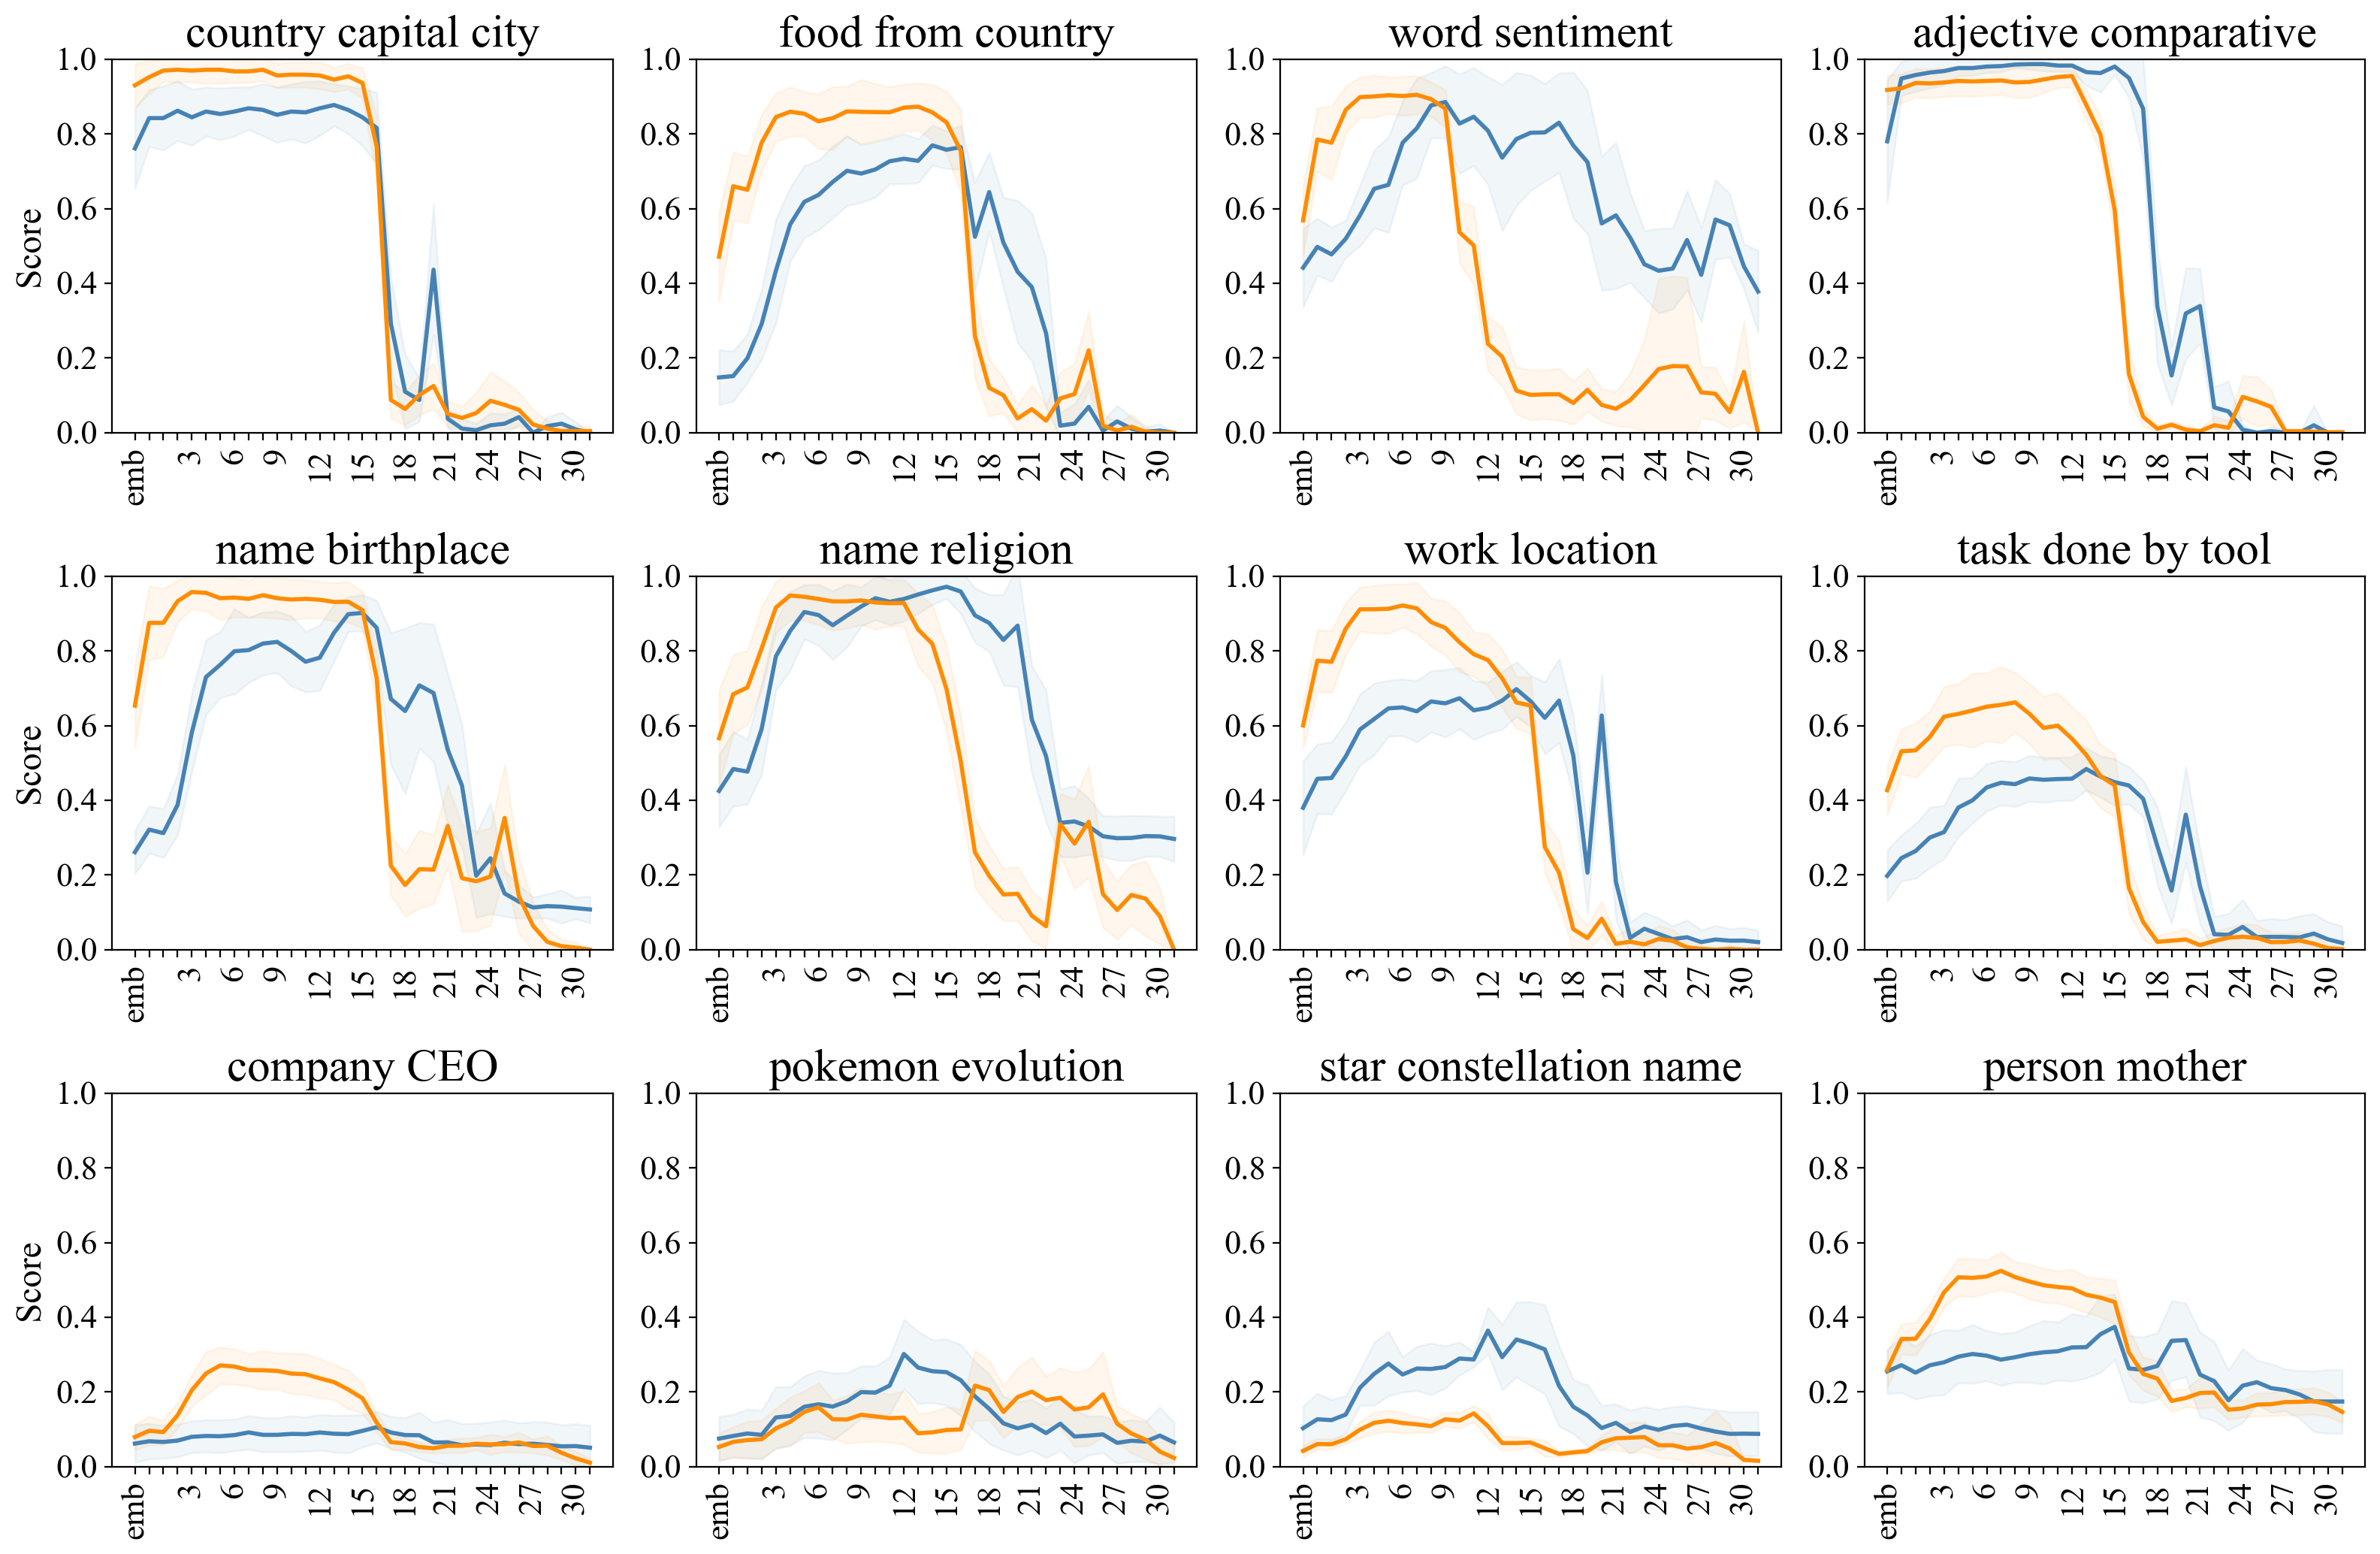

In [24]:
relation_names = [
    "country capital city", "food from country",
    "word sentiment", "adjective comparative",
    "name birthplace", "name religion",
    "work location", "task done by tool",
    "company CEO", "pokemon evolution", "star constellation name", "person mother"
]

#####################################################################################
plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=MEDIUM_SIZE+1)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=50)  # fontsize of the figure title
#####################################################################################

n_cols = 4
n_rows = int(np.ceil(len(relation_names)/n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 3.5))

axes = [axes] if n_rows == 1 else axes
axes = [axes] if n_cols == 1 else axes

selected_layers = [list(by_layer.keys())[0]] + list(by_layer.keys())[1::3][1:]
layers = list(by_layer.keys())
layer_labels = []
for layer in layers:
    if layer in selected_layers:
        layer_labels.append(layer)
    else:
        layer_labels.append("")

cur_row = 0
cur_col = 0
for relation_name in relation_names:
    relation_result = filtered_results[relation_name]
    ax = axes[cur_row][cur_col]
    print(relation_name, type(ax))
    plot_layerwise(ax, relation_result)
    plot_layerwise(ax, relation_result, attribute="efficacy", best_criterion="efficacy")
    ax.set_title(relation_result.relation_name, fontsize=BIGGER_SIZE)
    ax.set_xticks(range(len(layers)), layer_labels)
    if cur_col == 0:
        ax.set_ylabel("Score")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")

    if cur_col == 0 and cur_row == 0:
        legend = ax.legend(ncol=2, bbox_to_anchor=(0.5, 1.5), loc='upper center', frameon=False, fontsize=BIGGER_SIZE)
        export_legend(legend, f"{fig_dir}/legend-layerwise-sweep.pdf")
        legend.remove()

    cur_col += 1
    if cur_col == n_cols:
        cur_row += 1
        cur_col = 0


fig.tight_layout()
# plt.legend(ncol = 2, bbox_to_anchor=(0.5, 1.1), loc='upper center', frameon=False)
plt.savefig(f"{fig_dir}/{model_name}-sweeps.pdf", bbox_inches="tight")

fig.show()

## Causality vs Faithfulness Scatter Plots

In [25]:
def get_recall_vs_efficacy_info(sweep_results, criterion = "best", threshold = 30, beta = None):
    recalls = []
    efficacies = []
    pass_threshold = []
    labels = []
    for relation_name in sweep_results:
        if len(sweep_results[relation_name].trials) == 0:
            continue
        if criterion in ["best", "faithfulness"]:
            recalls.append(sweep_results[relation_name].best_by_faithfulness(beta = beta).recall.mean)
        else:
            recalls.append(sweep_results[relation_name].best_by_efficacy(beta = beta).recall.mean)
        if criterion in ["best", "efficacy"]:
            efficacies.append(sweep_results[relation_name].best_by_efficacy().efficacy.mean)
        else:
            efficacies.append(sweep_results[relation_name].best_by_faithfulness().efficacy.mean)
        
        test_samples = np.array([trial.n_test_samples for trial in sweep_results[relation_name].trials])
        pass_threshold.append(test_samples.min() >= threshold)
        labels.append(relation_name)

    return recalls, efficacies, pass_threshold, labels

/tmp/ipykernel_2658745/938723771.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


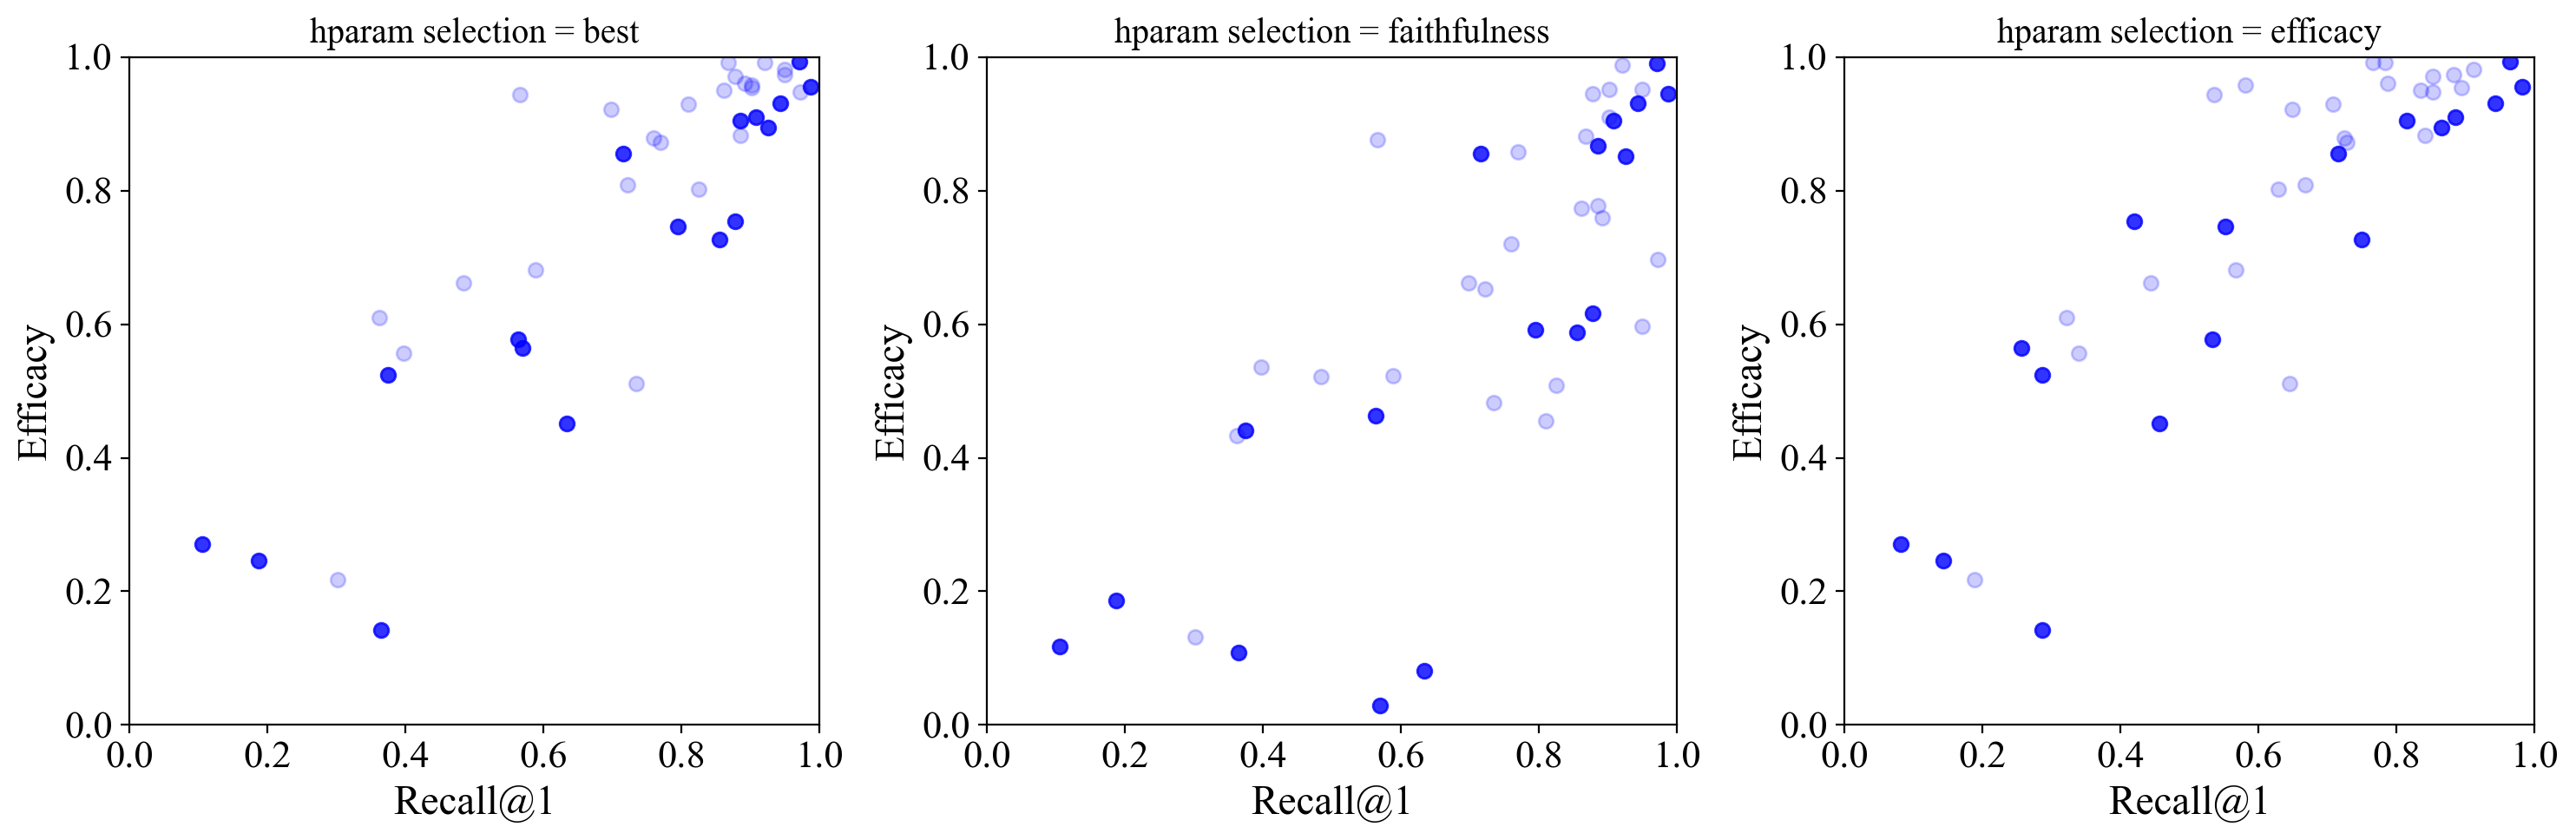

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for criterion, ax in zip(["best", "faithfulness", "efficacy"], axes):
    recalls, efficacies, pass_threshold, labels = get_recall_vs_efficacy_info(
        filtered_results, criterion=criterion, 
        # beta = 2.25
    )
    for recall, efficacy, threshold, relation_name in zip(recalls, efficacies, pass_threshold, labels):
        alpha = .8 if threshold else 0.2
        ax.scatter(recall, efficacy, color="blue", alpha=alpha)
        # if threshold and (recall/efficacy < .7 or efficacy/recall < .7):
        #     ax.annotate(relation_name, (recall, efficacy))


    ax.set_title(f"hparam selection = {criterion}")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Recall@1")
    ax.set_ylabel("Efficacy")

fig.tight_layout()
fig.show()

In [27]:
recalls, efficacies, pass_threshold, labels = get_recall_vs_efficacy_info(
    filtered_results, criterion=criterion, 
    beta = 4
)
correlation = np.corrcoef(recalls, efficacies)[0, 1]
correlation

0.6990786542214212

In [29]:
from sklearn.linear_model import LinearRegression
import torch

def get_linear_model(recalls: list[float], efficacies: list[float]):
    X = torch.Tensor(recalls)[None].T
    y = torch.Tensor(efficacies)[None].T
    lm = LinearRegression().fit(X = X, y = y)
    slope = torch.Tensor(lm.coef_).squeeze().item()
    y_intercept = torch.Tensor(lm.intercept_).squeeze().item()
    r_squared = lm.score(X, y)
    return slope, y_intercept, r_squared



In [31]:
beta_options = [beta.beta for beta in relation_result.trials[0].layers[0].result.betas]
beta_options

[0.0,
 0.25,
 0.5,
 0.75,
 1.0,
 1.25,
 1.5,
 1.75,
 2.0,
 2.25,
 2.5,
 2.75,
 3.0,
 3.25,
 3.5,
 3.75,
 4.0,
 4.25,
 4.5,
 4.75,
 5.0,
 5.25,
 5.5,
 5.75,
 6.0]

beta=0.0 | r_squared=0.08, slope=0.374, y_intercept=0.704
beta=0.25 | r_squared=0.11, slope=0.378, y_intercept=0.687
beta=0.5 | r_squared=0.16, slope=0.424, y_intercept=0.653
beta=0.75 | r_squared=0.30, slope=0.593, y_intercept=0.560
beta=1.0 | r_squared=0.49, slope=0.734, y_intercept=0.453
beta=1.25 | r_squared=0.59, slope=0.767, y_intercept=0.393
beta=1.5 | r_squared=0.65, slope=0.784, y_intercept=0.356
beta=1.75 | r_squared=0.68, slope=0.799, y_intercept=0.331
beta=2.0 | r_squared=0.69, slope=0.801, y_intercept=0.322
beta=2.25 | r_squared=0.69, slope=0.795, y_intercept=0.322
beta=2.5 | r_squared=0.66, slope=0.778, y_intercept=0.334
beta=2.75 | r_squared=0.64, slope=0.762, y_intercept=0.345
beta=3.0 | r_squared=0.61, slope=0.748, y_intercept=0.356
beta=3.25 | r_squared=0.58, slope=0.731, y_intercept=0.371
beta=3.5 | r_squared=0.55, slope=0.710, y_intercept=0.389
beta=3.75 | r_squared=0.52, slope=0.689, y_intercept=0.405
beta=4.0 | r_squared=0.49, slope=0.664, y_intercept=0.425
beta=4

/tmp/ipykernel_2658745/561082002.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


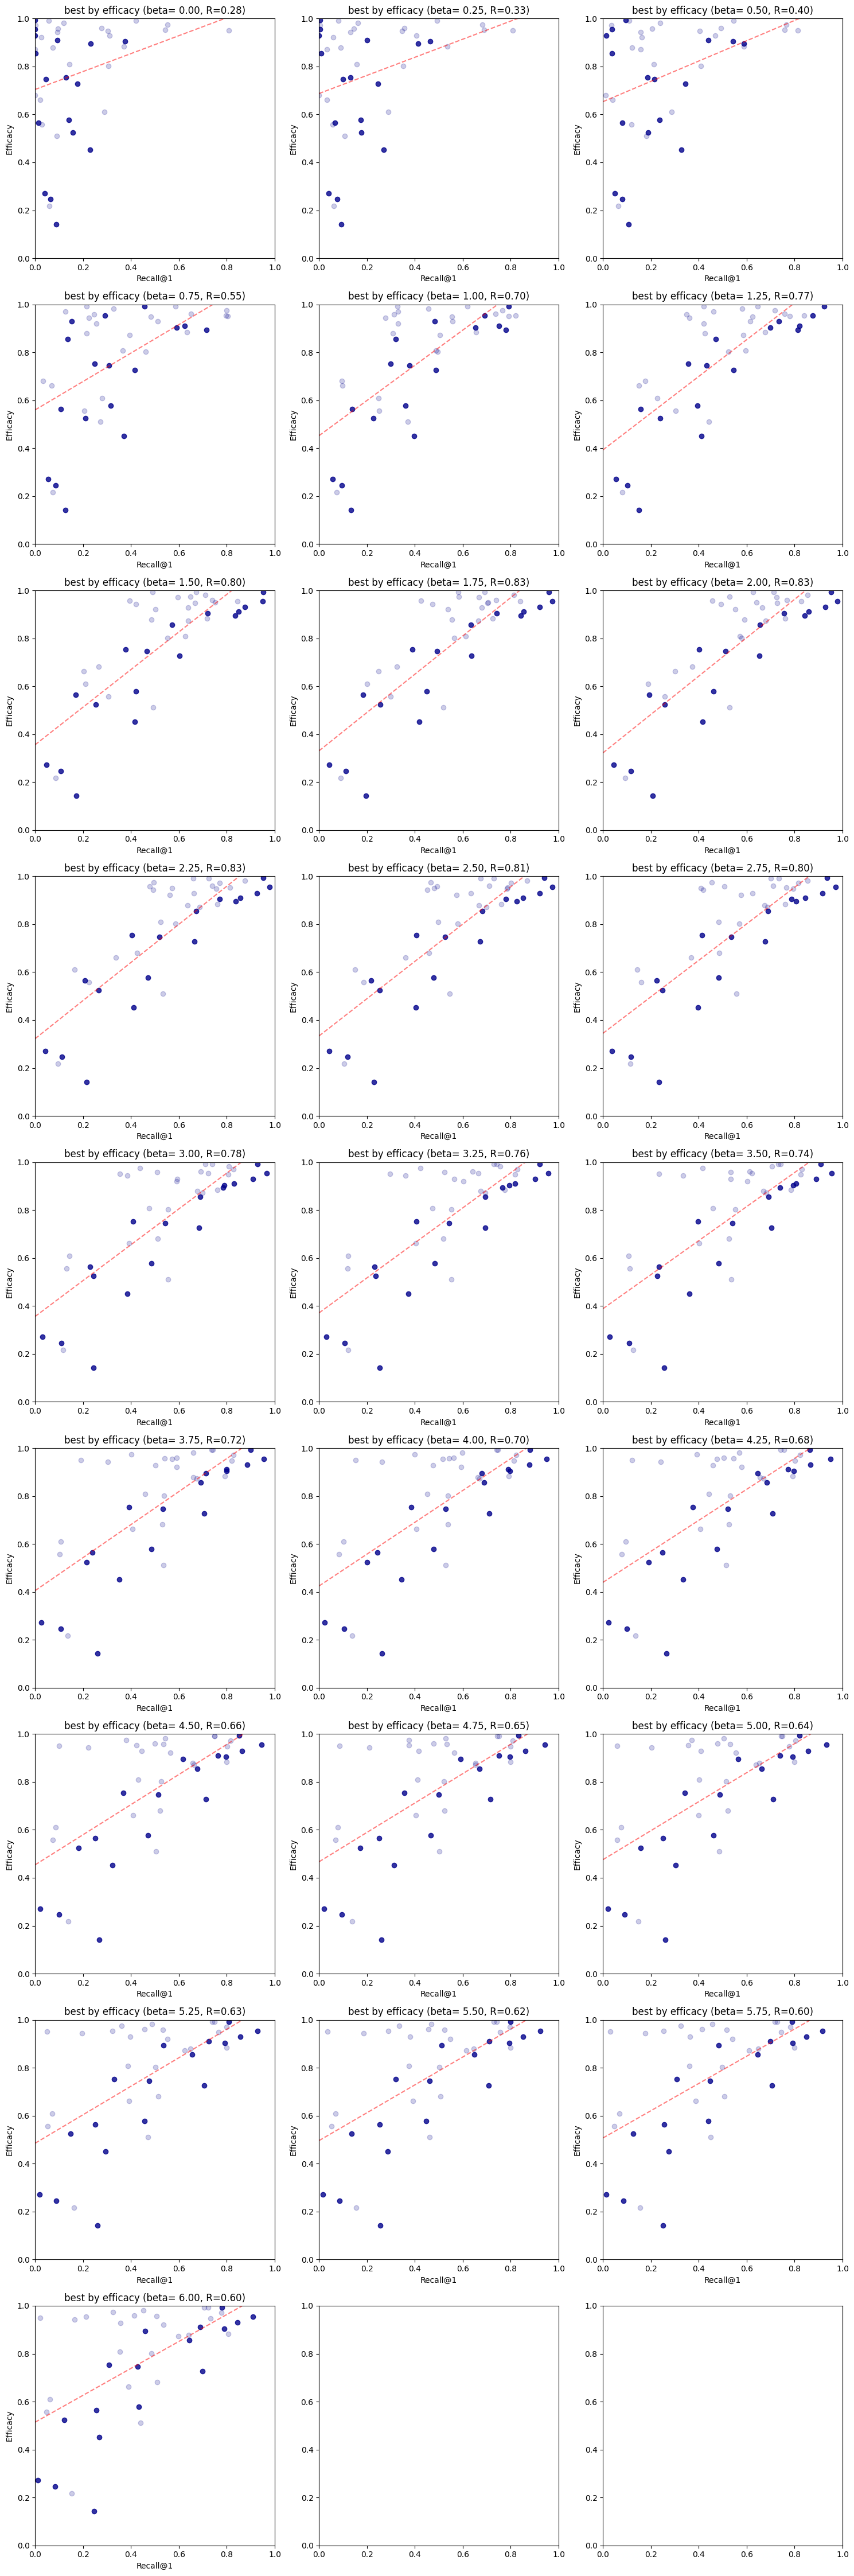

In [32]:
plt.rcdefaults()
num_figs = len(beta_options)
n_cols = 3
n_rows = int(np.ceil(num_figs/n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(5*n_cols, 5*n_rows))

scores_by_beta = []
cur_row, cur_col = 0, 0
for i, beta in enumerate(beta_options):
    recalls, efficacies, pass_threshold, labels = get_recall_vs_efficacy_info(filtered_results, criterion="efficacy", beta = beta)
    correlation = np.corrcoef(recalls, efficacies)[0, 1]

    scores_by_beta.append({
        "beta": f"{beta:.2f}",
        "recall_mean": f"{np.mean(recalls):.2f} ± {np.std(recalls):.2f}",
        "efficacy_mean": f"{np.mean(efficacies):.2f} ± {np.std(efficacies):.2f}",
        "R": f"{correlation:.2f}"
    })

    for recall, efficacy, threshold, relation_name in zip(recalls, efficacies, pass_threshold, labels):
        alpha = .8 if threshold else 0.2
        axes[cur_row][cur_col].scatter(recall, efficacy, color="darkblue", alpha=alpha)
        # if threshold and (recall/efficacy < .6 or efficacy/recall < .6):
        #     plt.annotate(relation_name, (recall, efficacy))

    slope, y_intercept, r_squared = get_linear_model(recalls, efficacies)

    print(f"{beta=} | {r_squared=:.2f}, {slope=:.3f}, {y_intercept=:.3f}")
    x = np.linspace(0, 1, 10)
    axes[cur_row][cur_col].plot(x, slope*x + y_intercept, color="red", linestyle="--", alpha=0.5)
    axes[cur_row][cur_col].set_title(
        f"best by efficacy (beta={beta : .2f}, R={correlation:.2f})", 
        # fontsize=BIGGER_SIZE
    )
    axes[cur_row][cur_col].set_xlim(0, 1)
    axes[cur_row][cur_col].set_ylim(0, 1)
    axes[cur_row][cur_col].set_xlabel("Recall@1")
    axes[cur_row][cur_col].set_ylabel("Efficacy")

    cur_col += 1
    if cur_col == n_cols:
        cur_row += 1
        cur_col = 0

fig.tight_layout()
fig.show()

Correlation: 0.83


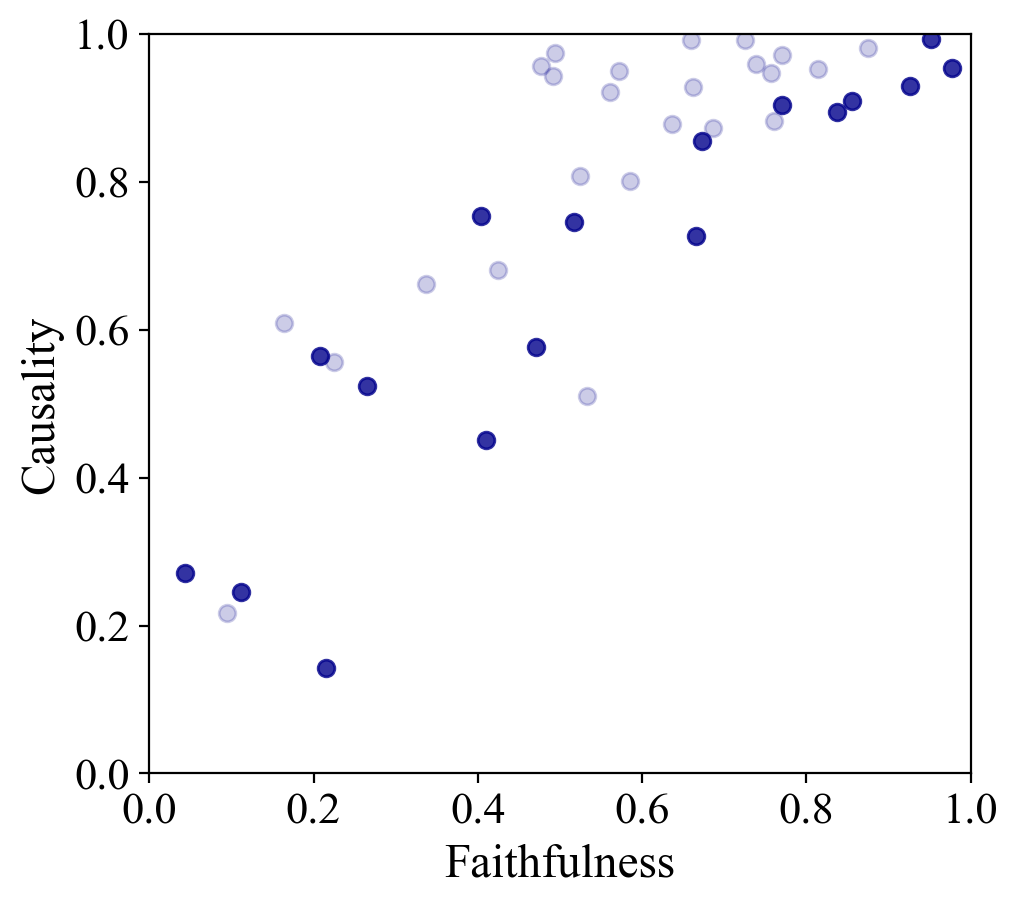

In [33]:
#####################################################################################
plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=MEDIUM_SIZE+1)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=50)  # fontsize of the figure title
#####################################################################################

# plt.rcdefaults()


recalls, efficacies, pass_threshold, labels = get_recall_vs_efficacy_info(
    filtered_results, 
    criterion="efficacy", # "faithfulness",
    beta=2.25 if "llama" not in model_name else 8.0
)
correlation = np.corrcoef(recalls, efficacies)[0, 1]
print(f"Correlation: {correlation :.2f}")

x = np.linspace(0, 1, 10)
slope, y_intercept, r_squared = get_linear_model(recalls, efficacies)
# plt.plot(x, slope*x + y_intercept, color="red", linestyle="--", alpha=0.5)

for recall, efficacy, threshold, relation_name in zip(recalls, efficacies, pass_threshold, labels):
    alpha = .8 if threshold else 0.2
    plt.scatter(recall, efficacy, color="darkblue", alpha=alpha)
    # plt.scatter(recall, efficacy, color="#1a0d00", alpha=alpha)
    dist = np.abs(slope * recall - efficacy + y_intercept)/(slope**2 + 1)**.5
    # if dist > 0.2:
    #     plt.annotate(relation_name, (recall, efficacy))

# plt.title(
#     f"Faithfulness vs Causality", # (Correlation={correlation :.2f})", 
#     fontsize=BIGGER_SIZE
# )
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Faithfulness")
plt.ylabel("Causality")
plt.gca().set_aspect('.9')
plt.savefig(f"{fig_dir}/{model_name}-efficacy_vs_faithfulness_faith.pdf", bbox_inches="tight")

plt.show()

In [34]:
import pandas as pd
df = pd.DataFrame(scores_by_beta)
# print(df[["beta", "recall_mean", "R"]].style.hide_index().to_latex())
os.makedirs("../../results/tables", exist_ok=True)
df.to_csv(f"../../results/tables/{model_name}-beta-R.csv", index=False)
df

/tmp/ipykernel_2658745/2551199854.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,beta,recall_mean,efficacy_mean,R
0,0.00,0.17 ± 0.18,0.77 ± 0.24,0.28
1,0.25,0.21 ± 0.21,0.77 ± 0.24,0.33
2,0.50,0.27 ± 0.22,0.77 ± 0.24,0.40
3,0.75,0.35 ± 0.22,0.77 ± 0.24,0.55
4,1.00,0.43 ± 0.23,0.77 ± 0.24,0.70
5,1.25,0.49 ± 0.24,0.77 ± 0.24,0.77
6,1.50,0.52 ± 0.24,0.77 ± 0.24,0.80
7,1.75,0.54 ± 0.24,0.77 ± 0.24,0.83
8,2.00,0.55 ± 0.25,0.77 ± 0.24,0.83
9,2.25,0.56 ± 0.25,0.77 ± 0.24,0.83


## Faithfulness

In [42]:
model_name_dict = {
    "gpt2-xl": "GPT2-xl",
    "gptj": "GPT-J",
    "llama-13b": "LLaMA-13B",
    "pythia-3b": "Pythia-3B",
}

In [38]:
import transformers

model_full_name = {
    "gptj": "EleutherAI/gpt-j-6B",
    "gpt2-xl": "gpt2-xl",
    "llama-13b": "/home/local_arnab/Codes/Weights/llama-13b",
    "pythia-3b": "EleutherAI/pythia-2.8b-deduped",
}

if "llama" in model_name:
    tokenizer = transformers.LlamaTokenizerFast.from_pretrained(model_full_name[model_name])
    tokenizer.pad_token = tokenizer.eos_token = "</s>"
    tokenizer.pad_token_id = tokenizer.eos_token_id = 2
else:
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_full_name[model_name])
    tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [39]:
filtered_results["country capital city"].best_by_efficacy(beta=2.25).recall

AggregateMetric(mean=0.7697368421052632, stdev=0.13402334728594317, stderr=0.02735740120586546, values=[0.8421052631578947, 0.631578947368421, 0.7894736842105263, 0.8421052631578947, 0.7368421052631579, 0.7894736842105263, 0.6842105263157895, 0.8947368421052632, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.8421052631578947, 0.7894736842105263, 0.47368421052631576, 0.5263157894736842, 0.42105263157894735, 0.8947368421052632, 0.8947368421052632, 0.8421052631578947, 0.8421052631578947, 0.8947368421052632, 0.8421052631578947, 0.8421052631578947, 0.9473684210526315])

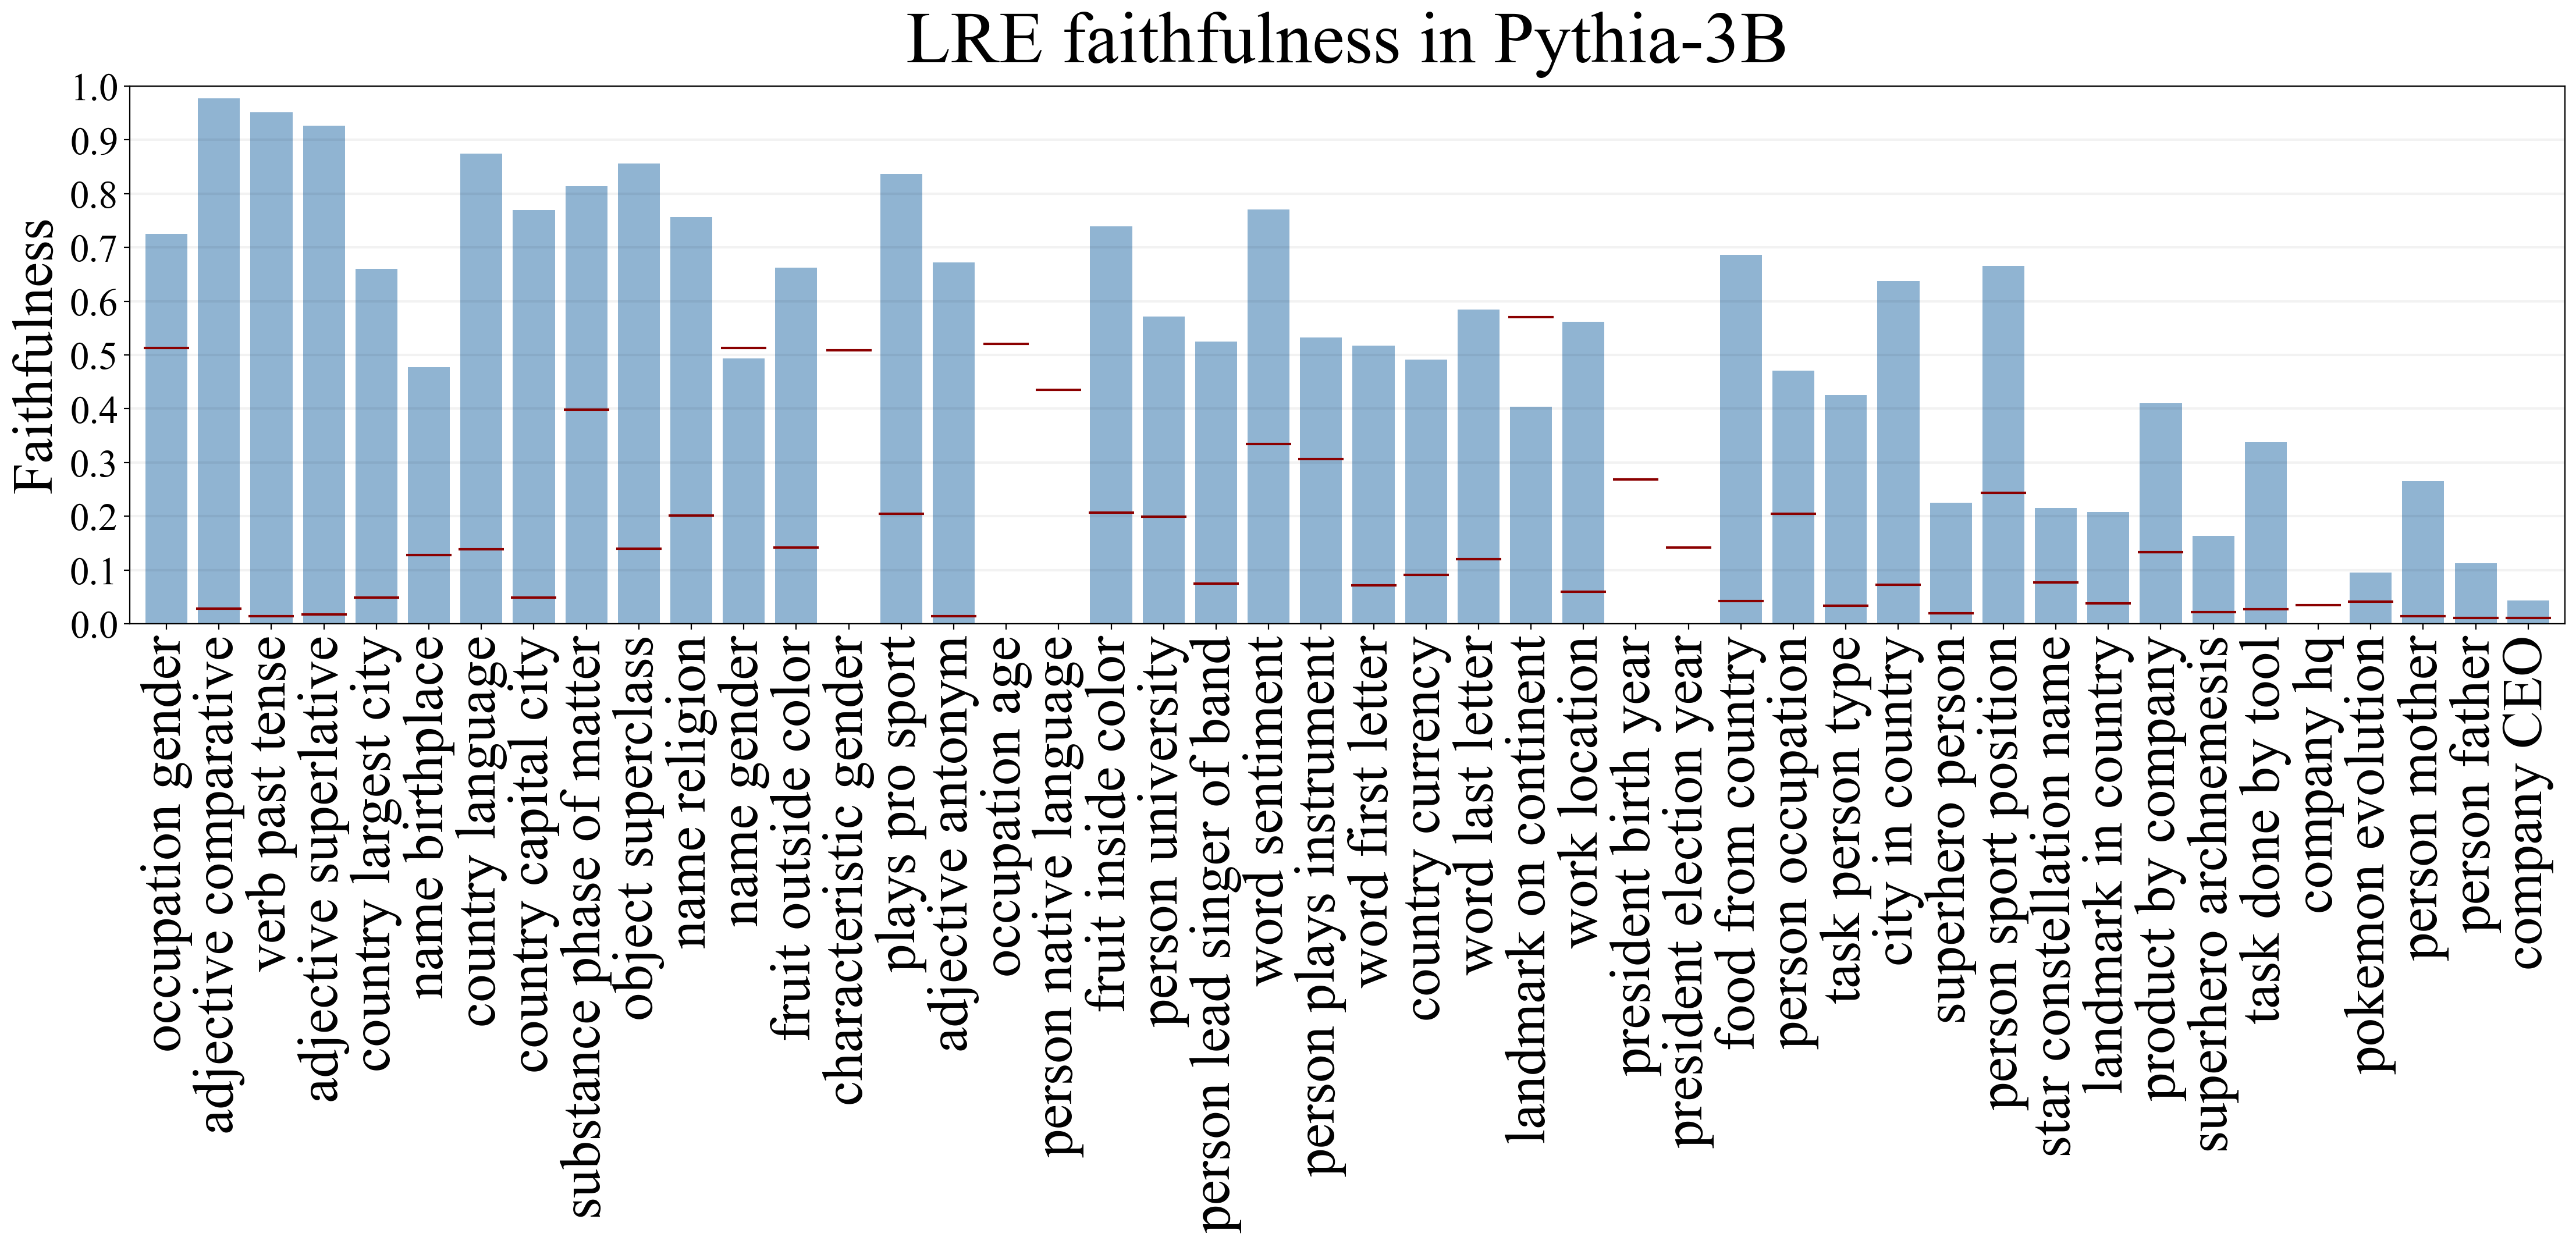

In [43]:
#####################################################################################
plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 28
MEDIUM_SIZE = 35
BIGGER_SIZE = 45

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE-4)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

relation_recall = []

for relation_name in filtered_results:
    relation_recall.append({
        "relation": relation_name,
        "recall@1": filtered_results[relation_name].best_by_efficacy(
            beta=2.25 if "llama" not in model_name else 8.0
        ).recall.mean
    })

if model_name == "gptj":
    relation_recall = sorted(relation_recall, key = lambda x: x["recall@1"])[::-1]
    with open(f"relation_order_{model_name}.json", "w") as f:
        json.dump(relation_recall, f)
    plot_info = relation_recall
else:
    with open("relation_order_gptj.json", "r") as f:
        relation_order = json.load(f)
    relation_recall = {r["relation"]: r["recall@1"] for r in relation_recall}

    plot_info = []

    for r in relation_order:
        relation = r["relation"]
        recall = relation_recall[relation] if relation in relation_recall else 0
        plot_info.append({
            "relation": relation,
            "recall@1": recall
        })
    
    with open(f"relation_order_{model_name}.json", "w") as f:
        json.dump(plot_info, f)


relations = [r["relation"] for r in plot_info]
recalls = [r["recall@1"] for r in plot_info]

# plt.figure(figsize = (10, 20))
# plt.barh(np.arange(len(relations)), recalls, color = "steelblue", alpha = 0.7)
# plt.yticks(np.arange(len(relations)), relations)
# plt.xticks(np.linspace(0, 1, 11), [np.round(v, 1) for v in np.linspace(0, 1, 11)])
# plt.ylim(-0.7,len(plot_info)-.3)
# plt.xlabel("Faithfulness")
# plt.xlim(0, 1)

plt.figure(figsize = (10, 20))
plt.bar(np.arange(len(relations)), recalls, color = "steelblue", alpha = 0.6)
plt.xticks(np.arange(len(relations)), relations, rotation=90)
plt.yticks(np.linspace(0, 1, 11), [np.round(v, 1) for v in np.linspace(0, 1, 11)])
plt.xlim(-0.7,len(plot_info)-.3)
plt.ylabel("Faithfulness", fontsize=MEDIUM_SIZE)
plt.ylim(0, 1)

# with open(f"../../results/tables/known/{model_name}.json") as f:
#     model_known = json.load(f)

for idx in range(len(plot_info)):
    relation_name = plot_info[idx]["relation"]
    d_relation = dataset.filter(relation_names=[relation_name])[0]
    ans_counter = {}
    for sample in d_relation.samples:
    # for sample in model_known[relation_name]["known_samples"]:
        obj = sample.object
        # obj = sample["object"]
        first_token = tokenizer(obj, return_tensors="pt").input_ids[0][1 if "llama" in model_name else 0]
        obj = tokenizer.decode(first_token)
        if obj not in ans_counter:
            ans_counter[obj] = 0
        ans_counter[obj] += 1
    # print(relation_name, end=": ")
    # majority_ans, majority_ans_count = max(ans_counter.items(), key = lambda x: x[1]) if len(ans_counter) > 0 else (0, 0)

    # # divide_by = len(model_known[relation_name]["known_samples"]) if len(ans_counter) > 0 else 1
    # divide_by = len(d_relation.samples)
    # print(f" -- {majority_ans} --- {majority_ans_count} / {divide_by}")
    # random_baseline = majority_ans_count/divide_by

    divide_by = len(d_relation.samples)
    random_baseline = 0
    for o, o_count in ans_counter.items():
        random_baseline += o_count**2
    random_baseline /= divide_by**2

    # print(ans_counter)
    # plt.scatter(random_baseline, idx, color = "darkred", alpha = 1, marker="|", s = 700)
    plt.scatter(idx, random_baseline, color = "darkred", alpha = 1, marker="_", s = 800)

for x_tick in np.linspace(0, 1, 11):
    # plt.axvline(x_tick, color = "black", alpha = 0.05)
    plt.axhline(x_tick, color = "black", alpha = 0.05)

plt.title(f"LRE faithfulness in {model_name_dict[model_name]}", pad=15, fontsize=BIGGER_SIZE)

fig = plt.gcf()
# fig.set_size_inches(10, 27)
fig.set_size_inches(27, 6)

plt.savefig(f"{fig_dir}/{model_name}-faithfulness_lre_relationwise.pdf", bbox_inches="tight")

plt.show()

## Generate Table

In [44]:
table = []
dataset = data.load_dataset()

for relation_name, sweep_result in filtered_results.items():
    efficacy_hparams = sweep_result.best_by_efficacy(beta=2.25 if "llama" not in model_name else 8.0)
    relation = dataset.filter(
        relation_names=[relation_name]
    )[0]
    table.append({
        "relation": relation_name,
        "n_range": len(relation.range),
        "layer": efficacy_hparams.layer,
        "beta": f"{efficacy_hparams.beta.mean: .2f} ± {efficacy_hparams.beta.stdev: .2f}",
        "rank": f"{int(efficacy_hparams.rank.mean)} ± {int(efficacy_hparams.rank.stdev)}",
        "recall@1": f"{efficacy_hparams.recall.mean: .2f} ± {efficacy_hparams.recall.stdev: .2f}",
        "efficacy": f"{efficacy_hparams.efficacy.mean: .2f} ± {efficacy_hparams.efficacy.stdev: .2f}",
        # "n_range": f"{len(relation.range)}",
    })

In [45]:
# sorted_table = sorted(table, key=lambda x: x["efficacy"], reverse=True)
sorted_table = sorted(table, key=lambda x: x["relation"])

In [46]:
df = pd.DataFrame(sorted_table)
os.makedirs("../../results/tables", exist_ok=True)
df.to_csv(f"../../results/tables/{model_name}-hparams.csv", index=False)
# print(df.to_markdown(index = False, tablefmt="github"))
# print(df.to_latex(index=False, escape=False))
df

,relation,n_range,layer,beta,rank,recall@1,efficacy
0,adjective antonym,95,9,2.25 ± 0.00,183 ± 65,0.67 ± 0.06,0.86 ± 0.05
1,adjective comparative,57,12,2.25 ± 0.00,178 ± 61,0.98 ± 0.02,0.95 ± 0.03
2,adjective superlative,79,12,2.25 ± 0.00,191 ± 65,0.93 ± 0.02,0.93 ± 0.03
3,city in country,21,7,2.25 ± 0.00,89 ± 44,0.64 ± 0.09,0.88 ± 0.08
4,company CEO,287,5,2.25 ± 0.00,126 ± 35,0.04 ± 0.03,0.27 ± 0.05
5,country capital city,24,5,2.25 ± 0.00,70 ± 62,0.77 ± 0.13,0.97 ± 0.04
6,country currency,23,3,2.25 ± 0.00,59 ± 26,0.49 ± 0.11,0.94 ± 0.04
7,country language,14,4,2.25 ± 0.00,62 ± 49,0.87 ± 0.06,0.98 ± 0.03
8,country largest city,24,6,2.25 ± 0.00,93 ± 62,0.66 ± 0.13,0.99 ± 0.03
9,food from country,26,13,2.25 ± 0.00,83 ± 66,0.69 ± 0.07,0.87 ± 0.06


### Single vs Multi token subjects

In [47]:
# def read_and_parse_sweep_results(sweep_path):
#     sweep_results = read_sweep_results(sweep_path)
#     for relation in sweep_results:
#         sweep_results[relation] = parse_results(sweep_results[relation])
#     return sweep_results

In [48]:
# sweep_single_path = f"../../results/sweep-single/{model_name}"
# sweep_single = read_and_parse_sweep_results(sweep_single_path)

# sweep_multi_path = f"../../results/sweep-multi/{model_name}"
# sweep_multi = read_and_parse_sweep_results(sweep_multi_path)

In [49]:
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4.5))

# for criterion, ax in zip(["best", "faithfulness", "efficacy"], axes):
#     single_recalls, single_efficacies, pass_single, single_labels = get_recall_vs_efficacy_info(sweep_single, criterion=criterion)
#     multi_recalls, multi_efficacies, pass_multi, multi_labels = get_recall_vs_efficacy_info(sweep_multi, criterion=criterion)
#     labeled = False
#     for r, e, p, l in zip(single_recalls, single_efficacies, pass_single, single_labels):
#         alpha = .8 if p else 0.2
#         if (alpha == 0.8 and not labeled):
#             ax.scatter(r, e, color = "blue", label = "single", alpha = alpha)
#             labeled = True
#         else:
#             ax.scatter(r, e, color = "blue", alpha = alpha)
#         if p and (r/e < .7 or e/r < .7):
#             ax.annotate(l, (r, e))

#     labeled = False
#     for r, e, p, l in zip(multi_recalls, multi_efficacies, pass_multi, multi_labels):
#         alpha = .8 if p else 0.2
#         alpha = .8 if p else 0.2
#         if (alpha == 0.8 and not labeled):
#             ax.scatter(r, e, color = "red", label = "multi", marker = "s", alpha = alpha)
#             labeled = True
#         else:
#             ax.scatter(r, e, color = "red", marker = "s", alpha = alpha)
#         if p and (r/e < .7 or e/r < .7):
#             ax.annotate(l, (r, e))

#     ax.set_title(f"Efficacy vs Recall ({criterion})")
#     ax.set_xlim(0, 1)
#     ax.set_ylim(0, 1)
#     ax.set_xlabel("Recall")
#     ax.set_ylabel("Efficacy")
#     ax.legend()